In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [2]:
images = []
organs = []
for organ in os.listdir('../organ_detection_wsi_data/Data'):
    for im_path in os.listdir(f'../organ_detection_wsi_data/Data/{organ}/tissue images'):
        if not im_path.endswith('.png'):
            continue

        im = cv2.imread(f'../organ_detection_wsi_data/Data/{organ}/tissue images/{im_path}')
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = im.astype(int)
        
        images.append(im)
        organs.append(organ)
        
len(images), images[0].shape, images[1].shape

(665, (512, 512, 3), (512, 512, 3))

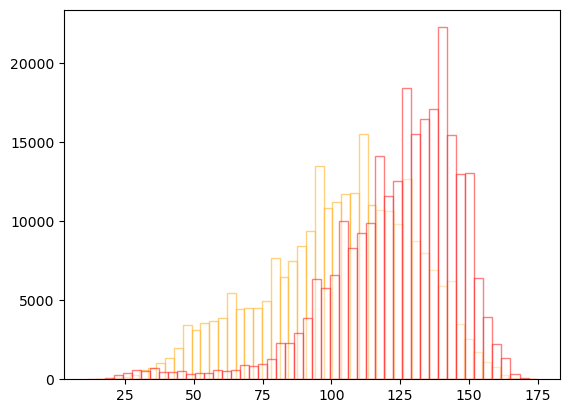

In [3]:
plt.hist(images[0].reshape(-1, 3)[:, 0], bins=50, alpha=0.5, color='white', edgecolor='orange')
plt.hist(images[1].reshape(-1, 3)[:, 0], bins=50, alpha=0.5, color='white', edgecolor='red')
plt.show()

In [4]:
import multiprocessing as mp
mp.cpu_count()

12

In [5]:
images[0].reshape(-1, 3).shape

(262144, 3)

In [6]:
tsne = TSNE(n_jobs=10)

im_pix = np.vstack(tuple([img.reshape(-1, 3) for img in images]))
print(im_pix.shape)

im_pix_rand = im_pix[np.random.choice(range(im_pix.shape[0]), 1000000), :]
im_emb = tsne.fit_transform(im_pix_rand)
im_emb

(174325760, 3)


array([[  83.4112  ,   21.302246],
       [ -83.686325,  -60.079353],
       [-101.32067 ,  -44.089687],
       ...,
       [ -61.731934, -116.17125 ],
       [-123.62354 ,   12.424276],
       [  71.487366,  -89.25204 ]], dtype=float32)

In [7]:
import pandas as pd

pd.DataFrame(im_emb).to_csv('image_embeddings.csv')

In [202]:
import pandas as pd
train_df = pd.Series(images)
label = pd.Series(organs)
index = pd.Series(range(train_df.shape[0]))
train_df = pd.concat([train_df, label, index], axis=1, keys=['X', 'label', 'index'])

organ_mapper = {}
for o in organs:
    class_id = len(organ_mapper)
    organ_mapper[o] = class_id - 1
train_df['label'] = train_df['label'].apply(lambda x: organ_mapper[x])

test_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)
train_df = train_df[~train_df['index'].isin(test_df['index'])].reset_index(drop=True)
print(train_df.tail())
# train_df = train_df.groupby('label', group_keys=False).sample(frac=1)
# train_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.reset_index(drop=True))
# test_df = test_df.groupby('label', group_keys=False).sample(frac=1)
# test_df = test_df.groupby('label', group_keys=False).apply(lambda x: x.reset_index(drop=True))
train_df.shape, test_df.shape

C:\Users\karth\AppData\Local\Temp\ipykernel_6404\4221810258.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)


                                                     X  label  index
595  [[[69, 29, 61], [75, 29, 61], [72, 30, 57], [7...     30    659
596  [[[114, 55, 82], [113, 55, 80], [109, 56, 81],...     30    661
597  [[[110, 64, 97], [99, 60, 97], [111, 65, 101],...     30    662
598  [[[113, 59, 91], [123, 59, 92], [112, 64, 84],...     30    663
599  [[[86, 41, 72], [95, 41, 70], [92, 45, 68], [9...     30    664


((600, 3), (65, 3))

In [204]:
test_df[test_df['label'] == 1]['X']

1    [[[107, 79, 112], [94, 77, 116], [90, 77, 108]...
Name: X, dtype: object

In [205]:
set(train_df['X'].apply(lambda x: x.dtype))

{dtype('int32')}

In [206]:
train_df = train_df.drop('index', axis=1)
test_df = test_df.drop('index', axis=1)
print(train_df.shape, train_df.shape)

(600, 2) (600, 2)


In [207]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(np.unique(organs))

from torchvision import models
import torch.nn as nn
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224


C:\Users\karth\anaconda3\envs\dev\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\karth\anaconda3\envs\dev\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [208]:
model_ft, input_size

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [209]:
model_ft.to(device) 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [210]:
import torchvision

params = {'batch_size': 40,
          'shuffle': True,
          'num_workers': 0,
          'pin_memory' : False}

class DL(torch.utils.data.Dataset):
    def __init__(self, imgs, labels, transform = None, target_patch_size = -1, num_classes = 10):
        self.labels = labels
        self.imgs = imgs
        self.target_patch_size = target_patch_size
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        self.ohe = {}
        self.num_classes = num_classes
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        X = self.imgs.loc[index]
        y = self.labels.loc[index]

        if self.target_patch_size is  not None:
            X = np.resize(X, (self.target_patch_size, self.target_patch_size, 3))
            X = np.array(X)
        if self.transform is not None:
            X = self.transform(X)
        return X, y

train_x, train_y = train_df['X'], train_df['label']
dl = DL(train_x, train_y, transform = torchvision.transforms.ToTensor, target_patch_size = input_size, num_classes = num_classes)
dl_gen = torch.utils.data.DataLoader(dl, **params)

val_x, val_y = test_df['X'], test_df['label']
dl_val = DL(val_x, val_y, transform = torchvision.transforms.ToTensor, target_patch_size = input_size, num_classes = num_classes)
dl_gen_val = torch.utils.data.DataLoader(dl_val, **params)

In [ ]:
import time

import torch.optim as optim
from tqdm import tqdm

noOfLayers = 0
for name, child in model_ft.named_children():
     noOfLayers += 1            
cut = int (.1 * noOfLayers)                
ct = 0
for name, child in model_ft.named_children():
    ct += 1
    if ct < cut:
        for name2, params in child.named_parameters():
            params.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()))

criterion = nn.CrossEntropyLoss()
print('\nSTART TRAINING ...', end = ' ')

class EarlyStopping:
    def __init__(self, patience = 20, stop_epoch = 50, verbose=False):

        self.patience = patience
        self.stop_epoch = stop_epoch
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, epoch, val_loss, model, ckpt_name = 'checkpoint.pt'):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, ckpt_name)
        elif score < self.best_score:
            self.counter += 1
            print(f'\nEarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience and epoch > self.stop_epoch:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, ckpt_name)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, ckpt_name):
        if self.verbose:
            print(f'\nValidation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), ckpt_name)
        self.val_loss_min = val_loss    
        
def Train_model_Classic(model, trainLoaders, valLoaders = [], criterion = None, optimizer = None, fold = False):    
    since = time.time()    
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []  

    for epoch in range(1000):
        phase = 'train'
        print('Epoch {}/{}\n'.format(epoch, 999))
        print('\nTRAINING...\n')        
        model.train() 
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(trainLoaders):
            inputs = inputs.to(device)
            labels = labels.to(device)        
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs.float())
                loss = criterion(outputs, labels)
                _, y_hat = torch.max(outputs, 1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(y_hat == labels.data)
        epoch_loss = running_loss / len(trainLoaders.dataset)
        epoch_acc = running_corrects.double() / len(trainLoaders.dataset)        
        train_acc_history.append(epoch_acc)
        train_loss_history.append(epoch_loss)        
        print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print()        
        if valLoaders:
            print('VALIDATION...\n')
            phase = 'val'    
            model.eval()        
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in tqdm(valLoaders):
                inputs = inputs.to(device)
                labels = labels.to(device)        
                with torch.set_grad_enabled(phase == 'train'):            
                    outputs = model(inputs.float())
                    loss = criterion(outputs, labels)
                    _, y_hat = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(y_hat == labels.data)        
            val_loss = running_loss / len(valLoaders.dataset)
            val_acc = running_corrects.double() / len(valLoaders.dataset)            
            val_acc_history.append(val_acc)
            val_loss_history.append(val_loss)
            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(phase, val_loss, val_acc)) 
            if fold == 'FULL':
                ckpt_name = os.path.join('./', "bestModel")
            else:
                ckpt_name = os.path.join('./', "bestModelFold" + fold)                         
            print('-' * 30)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model, train_loss_history, train_acc_history, val_acc_history, val_loss_history 
    
    
model, train_loss_history, train_acc_history, val_acc_history, val_loss_history = Train_model_Classic(model = model_ft,
                                 trainLoaders = dl_gen, valLoaders = dl_gen_val,
                                 criterion = criterion, optimizer = optimizer, fold = 'FULL')            
print('-' * 30)
        
torch.save(model_ft.state_dict(), os.path.join('./', 'RESULTS', 'finalModel'))                
history = pd.DataFrame(list(zip(train_loss_history, train_acc_history, val_acc_history, val_loss_history)), 
                  columns =['train_loss', 'train_acc', 'val_loss', 'val_acc'])                
history.to_csv(os.path.join('./', 'TRAIN_HISTORY_FULL' + '.csv'), index = False)



START TRAINING ... Epoch 0/999


TRAINING...



100%|██████████| 15/15 [01:52<00:00,  7.53s/it]



train Loss: 2.0935 Acc: 0.4000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.63s/it]



val Loss: 5.0284 Acc: 0.2000
------------------------------
Epoch 1/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.67s/it]



train Loss: 1.5131 Acc: 0.5333

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.05s/it]



val Loss: 5.8595 Acc: 0.2308
------------------------------
Epoch 2/999


TRAINING...



100%|██████████| 15/15 [01:53<00:00,  7.60s/it]



train Loss: 1.3177 Acc: 0.5650

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.76s/it]



val Loss: 1.8459 Acc: 0.4308
------------------------------
Epoch 3/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.45s/it]



train Loss: 1.0437 Acc: 0.6383

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.60s/it]



val Loss: 1.2167 Acc: 0.6308
------------------------------
Epoch 4/999


TRAINING...



100%|██████████| 15/15 [02:01<00:00,  8.07s/it]



train Loss: 1.0865 Acc: 0.6550

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.91s/it]



val Loss: 1.1582 Acc: 0.6462
------------------------------
Epoch 5/999


TRAINING...



100%|██████████| 15/15 [02:03<00:00,  8.23s/it]



train Loss: 1.0063 Acc: 0.6517

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.49s/it]



val Loss: 1.6029 Acc: 0.5385
------------------------------
Epoch 6/999


TRAINING...



100%|██████████| 15/15 [01:42<00:00,  6.81s/it]



train Loss: 0.8425 Acc: 0.7500

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.33s/it]



val Loss: 2.2190 Acc: 0.4462
------------------------------
Epoch 7/999


TRAINING...



100%|██████████| 15/15 [01:37<00:00,  6.52s/it]



train Loss: 0.6862 Acc: 0.7767

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.22s/it]



val Loss: 1.8808 Acc: 0.6000
------------------------------
Epoch 8/999


TRAINING...



100%|██████████| 15/15 [01:34<00:00,  6.31s/it]



train Loss: 0.6320 Acc: 0.8067

VALIDATION...



100%|██████████| 2/2 [00:03<00:00,  1.99s/it]



val Loss: 4.1338 Acc: 0.3538
------------------------------
Epoch 9/999


TRAINING...



100%|██████████| 15/15 [01:33<00:00,  6.24s/it]



train Loss: 0.6285 Acc: 0.7917

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.07s/it]



val Loss: 1.2090 Acc: 0.5846
------------------------------
Epoch 10/999


TRAINING...



100%|██████████| 15/15 [02:01<00:00,  8.09s/it]



train Loss: 0.6172 Acc: 0.7883

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.70s/it]



val Loss: 1.4555 Acc: 0.6462
------------------------------
Epoch 11/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.63s/it]



train Loss: 0.6163 Acc: 0.8033

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.82s/it]



val Loss: 2.0637 Acc: 0.5077
------------------------------
Epoch 12/999


TRAINING...



100%|██████████| 15/15 [01:55<00:00,  7.70s/it]



train Loss: 0.5053 Acc: 0.8333

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.79s/it]



val Loss: 2.4095 Acc: 0.4923
------------------------------
Epoch 13/999


TRAINING...



100%|██████████| 15/15 [02:05<00:00,  8.37s/it]



train Loss: 0.4826 Acc: 0.8450

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.92s/it]



val Loss: 2.4865 Acc: 0.3231
------------------------------
Epoch 14/999


TRAINING...



100%|██████████| 15/15 [02:14<00:00,  8.95s/it]



train Loss: 0.3967 Acc: 0.8817

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.02s/it]



val Loss: 1.7041 Acc: 0.5692
------------------------------
Epoch 15/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.05s/it]



train Loss: 0.5146 Acc: 0.8383

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.58s/it]



val Loss: 2.8002 Acc: 0.3692
------------------------------
Epoch 16/999


TRAINING...



100%|██████████| 15/15 [01:57<00:00,  7.81s/it]



train Loss: 0.4276 Acc: 0.8767

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.81s/it]



val Loss: 1.3881 Acc: 0.6000
------------------------------
Epoch 17/999


TRAINING...



100%|██████████| 15/15 [02:02<00:00,  8.20s/it]



train Loss: 0.3579 Acc: 0.8783

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.77s/it]



val Loss: 1.5697 Acc: 0.6154
------------------------------
Epoch 18/999


TRAINING...



100%|██████████| 15/15 [02:02<00:00,  8.17s/it]



train Loss: 0.2824 Acc: 0.8950

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.75s/it]



val Loss: 1.2976 Acc: 0.6769
------------------------------
Epoch 19/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.04s/it]



train Loss: 0.3138 Acc: 0.8983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.92s/it]



val Loss: 1.6703 Acc: 0.6462
------------------------------
Epoch 20/999


TRAINING...



100%|██████████| 15/15 [01:59<00:00,  7.95s/it]



train Loss: 0.2542 Acc: 0.9117

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.82s/it]



val Loss: 2.0982 Acc: 0.4769
------------------------------
Epoch 21/999


TRAINING...



100%|██████████| 15/15 [01:58<00:00,  7.88s/it]



train Loss: 0.2892 Acc: 0.9083

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.58s/it]



val Loss: 1.7324 Acc: 0.6000
------------------------------
Epoch 22/999


TRAINING...



100%|██████████| 15/15 [01:55<00:00,  7.72s/it]



train Loss: 0.2537 Acc: 0.9133

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.05s/it]



val Loss: 2.0857 Acc: 0.5385
------------------------------
Epoch 23/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.05s/it]



train Loss: 0.3210 Acc: 0.8950

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.69s/it]



val Loss: 2.8621 Acc: 0.4615
------------------------------
Epoch 24/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.06s/it]



train Loss: 0.2468 Acc: 0.9133

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.89s/it]



val Loss: 3.0205 Acc: 0.4000
------------------------------
Epoch 25/999


TRAINING...



100%|██████████| 15/15 [01:59<00:00,  7.98s/it]



train Loss: 0.2002 Acc: 0.9233

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.79s/it]



val Loss: 2.9602 Acc: 0.4308
------------------------------
Epoch 26/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.65s/it]



train Loss: 0.1655 Acc: 0.9517

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.61s/it]



val Loss: 1.4309 Acc: 0.6462
------------------------------
Epoch 27/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.65s/it]



train Loss: 0.1464 Acc: 0.9567

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.71s/it]



val Loss: 2.2055 Acc: 0.4923
------------------------------
Epoch 28/999


TRAINING...



100%|██████████| 15/15 [01:53<00:00,  7.60s/it]



train Loss: 0.1768 Acc: 0.9417

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.63s/it]



val Loss: 1.2965 Acc: 0.6923
------------------------------
Epoch 29/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.45s/it]



train Loss: 0.1708 Acc: 0.9367

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.60s/it]



val Loss: 2.4268 Acc: 0.5538
------------------------------
Epoch 30/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.62s/it]



train Loss: 0.2029 Acc: 0.9400

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.82s/it]



val Loss: 2.4876 Acc: 0.5538
------------------------------
Epoch 31/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.03s/it]



train Loss: 0.1705 Acc: 0.9383

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.91s/it]



val Loss: 3.3884 Acc: 0.4462
------------------------------
Epoch 32/999


TRAINING...



100%|██████████| 15/15 [02:01<00:00,  8.10s/it]



train Loss: 0.1545 Acc: 0.9517

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.89s/it]



val Loss: 2.9731 Acc: 0.5385
------------------------------
Epoch 33/999


TRAINING...



100%|██████████| 15/15 [02:21<00:00,  9.41s/it]



train Loss: 0.1399 Acc: 0.9567

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.89s/it]



val Loss: 2.4370 Acc: 0.5538
------------------------------
Epoch 34/999


TRAINING...



100%|██████████| 15/15 [02:18<00:00,  9.22s/it]



train Loss: 0.1281 Acc: 0.9567

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.80s/it]



val Loss: 2.4181 Acc: 0.4923
------------------------------
Epoch 35/999


TRAINING...



100%|██████████| 15/15 [02:09<00:00,  8.63s/it]



train Loss: 0.0732 Acc: 0.9817

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.80s/it]



val Loss: 1.3576 Acc: 0.6000
------------------------------
Epoch 36/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.04s/it]



train Loss: 0.0480 Acc: 0.9867

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.75s/it]



val Loss: 1.1463 Acc: 0.7231
------------------------------
Epoch 37/999


TRAINING...



100%|██████████| 15/15 [01:59<00:00,  7.98s/it]



train Loss: 0.0554 Acc: 0.9767

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.91s/it]



val Loss: 1.2234 Acc: 0.7077
------------------------------
Epoch 38/999


TRAINING...



100%|██████████| 15/15 [01:59<00:00,  8.00s/it]



train Loss: 0.0600 Acc: 0.9850

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.76s/it]



val Loss: 1.3975 Acc: 0.7077
------------------------------
Epoch 39/999


TRAINING...



100%|██████████| 15/15 [01:57<00:00,  7.85s/it]



train Loss: 0.0614 Acc: 0.9800

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.77s/it]



val Loss: 1.6010 Acc: 0.6769
------------------------------
Epoch 40/999


TRAINING...



100%|██████████| 15/15 [01:55<00:00,  7.70s/it]



train Loss: 0.0548 Acc: 0.9800

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.58s/it]



val Loss: 2.0242 Acc: 0.6000
------------------------------
Epoch 41/999


TRAINING...



100%|██████████| 15/15 [01:59<00:00,  7.99s/it]



train Loss: 0.0507 Acc: 0.9867

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.79s/it]



val Loss: 1.5601 Acc: 0.6923
------------------------------
Epoch 42/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.01s/it]



train Loss: 0.0374 Acc: 0.9933

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.70s/it]



val Loss: 1.3583 Acc: 0.6923
------------------------------
Epoch 43/999


TRAINING...



100%|██████████| 15/15 [01:56<00:00,  7.79s/it]



train Loss: 0.0776 Acc: 0.9767

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.67s/it]



val Loss: 1.5514 Acc: 0.6615
------------------------------
Epoch 44/999


TRAINING...



100%|██████████| 15/15 [01:56<00:00,  7.74s/it]



train Loss: 0.0583 Acc: 0.9833

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.75s/it]



val Loss: 1.5199 Acc: 0.6923
------------------------------
Epoch 45/999


TRAINING...



100%|██████████| 15/15 [01:57<00:00,  7.82s/it]



train Loss: 0.0312 Acc: 0.9917

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.78s/it]



val Loss: 1.4925 Acc: 0.6769
------------------------------
Epoch 46/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.02s/it]



train Loss: 0.0402 Acc: 0.9867

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.83s/it]



val Loss: 2.0355 Acc: 0.6308
------------------------------
Epoch 47/999


TRAINING...



100%|██████████| 15/15 [01:58<00:00,  7.91s/it]



train Loss: 0.0625 Acc: 0.9750

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.71s/it]



val Loss: 1.9186 Acc: 0.5538
------------------------------
Epoch 48/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.41s/it]



train Loss: 0.0609 Acc: 0.9817

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.82s/it]



val Loss: 1.7707 Acc: 0.6615
------------------------------
Epoch 49/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.41s/it]



train Loss: 0.1413 Acc: 0.9517

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.63s/it]



val Loss: 1.8830 Acc: 0.7077
------------------------------
Epoch 50/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.46s/it]



train Loss: 0.2585 Acc: 0.9267

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.61s/it]



val Loss: 3.4137 Acc: 0.4769
------------------------------
Epoch 51/999


TRAINING...



100%|██████████| 15/15 [01:53<00:00,  7.54s/it]



train Loss: 0.0846 Acc: 0.9750

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.72s/it]



val Loss: 1.7109 Acc: 0.6308
------------------------------
Epoch 52/999


TRAINING...



100%|██████████| 15/15 [01:53<00:00,  7.57s/it]



train Loss: 0.1412 Acc: 0.9600

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.68s/it]



val Loss: 1.5959 Acc: 0.6923
------------------------------
Epoch 53/999


TRAINING...



100%|██████████| 15/15 [01:53<00:00,  7.54s/it]



train Loss: 0.0672 Acc: 0.9817

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.81s/it]



val Loss: 2.3100 Acc: 0.6000
------------------------------
Epoch 54/999


TRAINING...



100%|██████████| 15/15 [02:05<00:00,  8.37s/it]



train Loss: 0.0824 Acc: 0.9750

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.03s/it]



val Loss: 1.9346 Acc: 0.5692
------------------------------
Epoch 55/999


TRAINING...



100%|██████████| 15/15 [01:58<00:00,  7.93s/it]



train Loss: 0.0995 Acc: 0.9683

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.88s/it]



val Loss: 1.8172 Acc: 0.6154
------------------------------
Epoch 56/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.61s/it]



train Loss: 0.0675 Acc: 0.9833

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.61s/it]



val Loss: 1.3941 Acc: 0.6769
------------------------------
Epoch 57/999


TRAINING...



100%|██████████| 15/15 [01:52<00:00,  7.52s/it]



train Loss: 0.0643 Acc: 0.9767

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.61s/it]



val Loss: 1.0239 Acc: 0.7231
------------------------------
Epoch 58/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.18s/it]



train Loss: 0.0391 Acc: 0.9900

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.68s/it]



val Loss: 1.7300 Acc: 0.6923
------------------------------
Epoch 59/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.03s/it]



train Loss: 0.0671 Acc: 0.9767

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.74s/it]



val Loss: 1.8462 Acc: 0.7077
------------------------------
Epoch 60/999


TRAINING...



100%|██████████| 15/15 [02:25<00:00,  9.69s/it]



train Loss: 0.1021 Acc: 0.9683

VALIDATION...



100%|██████████| 2/2 [00:07<00:00,  3.68s/it]



val Loss: 3.1289 Acc: 0.4615
------------------------------
Epoch 61/999


TRAINING...



100%|██████████| 15/15 [03:07<00:00, 12.47s/it]



train Loss: 0.0985 Acc: 0.9633

VALIDATION...



100%|██████████| 2/2 [00:08<00:00,  4.12s/it]



val Loss: 3.2597 Acc: 0.4462
------------------------------
Epoch 62/999


TRAINING...



100%|██████████| 15/15 [03:30<00:00, 14.03s/it]



train Loss: 0.1047 Acc: 0.9700

VALIDATION...



100%|██████████| 2/2 [00:08<00:00,  4.09s/it]



val Loss: 2.1906 Acc: 0.5846
------------------------------
Epoch 63/999


TRAINING...



100%|██████████| 15/15 [02:56<00:00, 11.75s/it]



train Loss: 0.1069 Acc: 0.9717

VALIDATION...



100%|██████████| 2/2 [00:07<00:00,  3.94s/it]



val Loss: 2.3162 Acc: 0.6462
------------------------------
Epoch 64/999


TRAINING...



100%|██████████| 15/15 [02:43<00:00, 10.88s/it]



train Loss: 0.1140 Acc: 0.9633

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.35s/it]



val Loss: 2.0537 Acc: 0.6154
------------------------------
Epoch 65/999


TRAINING...



100%|██████████| 15/15 [03:12<00:00, 12.84s/it]



train Loss: 0.0841 Acc: 0.9767

VALIDATION...



100%|██████████| 2/2 [00:11<00:00,  5.59s/it]



val Loss: 1.5130 Acc: 0.6769
------------------------------
Epoch 66/999


TRAINING...



100%|██████████| 15/15 [03:05<00:00, 12.35s/it]



train Loss: 0.0778 Acc: 0.9733

VALIDATION...



100%|██████████| 2/2 [00:08<00:00,  4.19s/it]



val Loss: 2.4209 Acc: 0.5846
------------------------------
Epoch 67/999


TRAINING...



100%|██████████| 15/15 [02:59<00:00, 11.99s/it]



train Loss: 0.0351 Acc: 0.9917

VALIDATION...



100%|██████████| 2/2 [00:07<00:00,  4.00s/it]



val Loss: 1.3941 Acc: 0.6769
------------------------------
Epoch 68/999


TRAINING...



100%|██████████| 15/15 [02:57<00:00, 11.85s/it]



train Loss: 0.0234 Acc: 0.9950

VALIDATION...



100%|██████████| 2/2 [00:08<00:00,  4.49s/it]



val Loss: 1.6585 Acc: 0.6462
------------------------------
Epoch 69/999


TRAINING...



100%|██████████| 15/15 [02:53<00:00, 11.55s/it]



train Loss: 0.0404 Acc: 0.9867

VALIDATION...



100%|██████████| 2/2 [00:07<00:00,  3.83s/it]



val Loss: 1.5874 Acc: 0.6154
------------------------------
Epoch 70/999


TRAINING...



100%|██████████| 15/15 [02:53<00:00, 11.60s/it]



train Loss: 0.0421 Acc: 0.9883

VALIDATION...



100%|██████████| 2/2 [00:07<00:00,  3.76s/it]



val Loss: 1.8529 Acc: 0.6308
------------------------------
Epoch 71/999


TRAINING...



100%|██████████| 15/15 [02:50<00:00, 11.38s/it]



train Loss: 0.0342 Acc: 0.9900

VALIDATION...



100%|██████████| 2/2 [00:08<00:00,  4.20s/it]



val Loss: 1.5136 Acc: 0.7077
------------------------------
Epoch 72/999


TRAINING...



100%|██████████| 15/15 [02:45<00:00, 11.01s/it]



train Loss: 0.0232 Acc: 0.9950

VALIDATION...



100%|██████████| 2/2 [00:08<00:00,  4.11s/it]



val Loss: 1.2696 Acc: 0.6769
------------------------------
Epoch 73/999


TRAINING...



100%|██████████| 15/15 [02:41<00:00, 10.76s/it]



train Loss: 0.0271 Acc: 0.9950

VALIDATION...



100%|██████████| 2/2 [00:07<00:00,  3.64s/it]



val Loss: 1.2482 Acc: 0.7692
------------------------------
Epoch 74/999


TRAINING...



100%|██████████| 15/15 [02:37<00:00, 10.49s/it]



train Loss: 0.0163 Acc: 0.9950

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.36s/it]



val Loss: 1.7458 Acc: 0.6462
------------------------------
Epoch 75/999


TRAINING...



100%|██████████| 15/15 [02:43<00:00, 10.89s/it]



train Loss: 0.0229 Acc: 0.9950

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.33s/it]



val Loss: 1.5909 Acc: 0.6615
------------------------------
Epoch 76/999


TRAINING...



100%|██████████| 15/15 [02:51<00:00, 11.44s/it]



train Loss: 0.0076 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:07<00:00,  3.59s/it]



val Loss: 1.5875 Acc: 0.6615
------------------------------
Epoch 77/999


TRAINING...



100%|██████████| 15/15 [02:27<00:00,  9.86s/it]



train Loss: 0.0066 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.74s/it]



val Loss: 1.5155 Acc: 0.6769
------------------------------
Epoch 78/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.14s/it]



train Loss: 0.0059 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.63s/it]



val Loss: 1.6018 Acc: 0.6615
------------------------------
Epoch 79/999


TRAINING...



100%|██████████| 15/15 [01:45<00:00,  7.04s/it]



train Loss: 0.0028 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.45s/it]



val Loss: 1.5074 Acc: 0.7077
------------------------------
Epoch 80/999


TRAINING...



100%|██████████| 15/15 [01:45<00:00,  7.01s/it]



train Loss: 0.0057 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.66s/it]



val Loss: 1.5677 Acc: 0.6769
------------------------------
Epoch 81/999


TRAINING...



100%|██████████| 15/15 [01:45<00:00,  7.02s/it]



train Loss: 0.0045 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.55s/it]



val Loss: 1.5905 Acc: 0.6769
------------------------------
Epoch 82/999


TRAINING...



100%|██████████| 15/15 [01:42<00:00,  6.86s/it]



train Loss: 0.0059 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.49s/it]



val Loss: 1.4357 Acc: 0.6769
------------------------------
Epoch 83/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.14s/it]



train Loss: 0.0071 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.66s/it]



val Loss: 1.5030 Acc: 0.6923
------------------------------
Epoch 84/999


TRAINING...



100%|██████████| 15/15 [01:55<00:00,  7.68s/it]



train Loss: 0.0032 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.68s/it]



val Loss: 1.4923 Acc: 0.6923
------------------------------
Epoch 85/999


TRAINING...



100%|██████████| 15/15 [02:07<00:00,  8.48s/it]



train Loss: 0.0053 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.92s/it]



val Loss: 1.4993 Acc: 0.6923
------------------------------
Epoch 86/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.04s/it]



train Loss: 0.0032 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.72s/it]



val Loss: 1.5083 Acc: 0.6462
------------------------------
Epoch 87/999


TRAINING...



100%|██████████| 15/15 [02:00<00:00,  8.03s/it]



train Loss: 0.0028 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.59s/it]



val Loss: 1.4807 Acc: 0.6462
------------------------------
Epoch 88/999


TRAINING...



100%|██████████| 15/15 [01:53<00:00,  7.58s/it]



train Loss: 0.0011 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.75s/it]



val Loss: 1.3956 Acc: 0.6615
------------------------------
Epoch 89/999


TRAINING...



100%|██████████| 15/15 [01:56<00:00,  7.79s/it]



train Loss: 0.0009 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.70s/it]



val Loss: 1.3763 Acc: 0.6923
------------------------------
Epoch 90/999


TRAINING...



100%|██████████| 15/15 [02:11<00:00,  8.74s/it]



train Loss: 0.0018 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.67s/it]



val Loss: 1.3714 Acc: 0.7077
------------------------------
Epoch 91/999


TRAINING...



100%|██████████| 15/15 [02:02<00:00,  8.17s/it]



train Loss: 0.0012 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.15s/it]



val Loss: 1.3516 Acc: 0.6923
------------------------------
Epoch 92/999


TRAINING...



100%|██████████| 15/15 [02:17<00:00,  9.17s/it]



train Loss: 0.0009 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.18s/it]



val Loss: 1.3797 Acc: 0.7077
------------------------------
Epoch 93/999


TRAINING...



100%|██████████| 15/15 [01:56<00:00,  7.77s/it]



train Loss: 0.0007 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:06<00:00,  3.14s/it]



val Loss: 1.3382 Acc: 0.6923
------------------------------
Epoch 94/999


TRAINING...



100%|██████████| 15/15 [02:05<00:00,  8.35s/it]



train Loss: 0.0007 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.57s/it]



val Loss: 1.3612 Acc: 0.7077
------------------------------
Epoch 95/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.46s/it]



train Loss: 0.0007 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.57s/it]



val Loss: 1.3530 Acc: 0.7231
------------------------------
Epoch 96/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.15s/it]



train Loss: 0.0008 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.68s/it]



val Loss: 1.3823 Acc: 0.7077
------------------------------
Epoch 97/999


TRAINING...



100%|██████████| 15/15 [01:48<00:00,  7.24s/it]



train Loss: 0.0023 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.50s/it]



val Loss: 1.3545 Acc: 0.6923
------------------------------
Epoch 98/999


TRAINING...



100%|██████████| 15/15 [01:50<00:00,  7.35s/it]



train Loss: 0.0014 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.59s/it]



val Loss: 1.3643 Acc: 0.6923
------------------------------
Epoch 99/999


TRAINING...



100%|██████████| 15/15 [01:52<00:00,  7.50s/it]



train Loss: 0.0077 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.57s/it]



val Loss: 1.6366 Acc: 0.6923
------------------------------
Epoch 100/999


TRAINING...



100%|██████████| 15/15 [01:49<00:00,  7.33s/it]



train Loss: 0.0079 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.47s/it]



val Loss: 1.9921 Acc: 0.6769
------------------------------
Epoch 101/999


TRAINING...



100%|██████████| 15/15 [01:48<00:00,  7.23s/it]



train Loss: 0.0086 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.55s/it]



val Loss: 1.6869 Acc: 0.6769
------------------------------
Epoch 102/999


TRAINING...



100%|██████████| 15/15 [01:46<00:00,  7.08s/it]



train Loss: 0.0065 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.58s/it]



val Loss: 1.8814 Acc: 0.6615
------------------------------
Epoch 103/999


TRAINING...



100%|██████████| 15/15 [01:46<00:00,  7.12s/it]



train Loss: 0.0109 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.53s/it]



val Loss: 1.5343 Acc: 0.6923
------------------------------
Epoch 104/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.14s/it]



train Loss: 0.0097 Acc: 0.9950

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.48s/it]



val Loss: 1.6674 Acc: 0.6615
------------------------------
Epoch 105/999


TRAINING...



100%|██████████| 15/15 [01:45<00:00,  7.00s/it]



train Loss: 0.0134 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.48s/it]



val Loss: 2.0070 Acc: 0.6308
------------------------------
Epoch 106/999


TRAINING...



100%|██████████| 15/15 [01:41<00:00,  6.74s/it]



train Loss: 0.0489 Acc: 0.9883

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.54s/it]



val Loss: 3.1232 Acc: 0.5077
------------------------------
Epoch 107/999


TRAINING...



100%|██████████| 15/15 [01:44<00:00,  6.97s/it]



train Loss: 0.0272 Acc: 0.9950

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.48s/it]



val Loss: 2.4928 Acc: 0.6154
------------------------------
Epoch 108/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.65s/it]



train Loss: 0.0305 Acc: 0.9867

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.44s/it]



val Loss: 1.9472 Acc: 0.6462
------------------------------
Epoch 109/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.16s/it]



train Loss: 0.0107 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.50s/it]



val Loss: 1.8109 Acc: 0.6769
------------------------------
Epoch 110/999


TRAINING...



100%|██████████| 15/15 [01:46<00:00,  7.11s/it]



train Loss: 0.0162 Acc: 0.9933

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.53s/it]



val Loss: 2.2971 Acc: 0.6615
------------------------------
Epoch 111/999


TRAINING...



100%|██████████| 15/15 [01:43<00:00,  6.87s/it]



train Loss: 0.0224 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.67s/it]



val Loss: 2.0702 Acc: 0.5846
------------------------------
Epoch 112/999


TRAINING...



100%|██████████| 15/15 [01:46<00:00,  7.08s/it]



train Loss: 0.0186 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.65s/it]



val Loss: 2.1638 Acc: 0.6154
------------------------------
Epoch 113/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.17s/it]



train Loss: 0.0587 Acc: 0.9817

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.55s/it]



val Loss: 3.0376 Acc: 0.6000
------------------------------
Epoch 114/999


TRAINING...



100%|██████████| 15/15 [01:49<00:00,  7.33s/it]



train Loss: 0.1435 Acc: 0.9550

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.79s/it]



val Loss: 3.8124 Acc: 0.4923
------------------------------
Epoch 115/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.16s/it]



train Loss: 0.1535 Acc: 0.9500

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.43s/it]



val Loss: 2.6998 Acc: 0.5385
------------------------------
Epoch 116/999


TRAINING...



100%|██████████| 15/15 [01:40<00:00,  6.69s/it]



train Loss: 0.2086 Acc: 0.9517

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.65s/it]



val Loss: 3.6295 Acc: 0.4308
------------------------------
Epoch 117/999


TRAINING...



100%|██████████| 15/15 [01:41<00:00,  6.76s/it]



train Loss: 0.1976 Acc: 0.9317

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.56s/it]



val Loss: 3.4658 Acc: 0.3692
------------------------------
Epoch 118/999


TRAINING...



100%|██████████| 15/15 [01:41<00:00,  6.75s/it]



train Loss: 0.1763 Acc: 0.9417

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.14s/it]



val Loss: 3.7639 Acc: 0.3846
------------------------------
Epoch 119/999


TRAINING...



100%|██████████| 15/15 [01:46<00:00,  7.13s/it]



train Loss: 0.2842 Acc: 0.9183

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.57s/it]



val Loss: 3.1648 Acc: 0.4462
------------------------------
Epoch 120/999


TRAINING...



100%|██████████| 15/15 [01:48<00:00,  7.25s/it]



train Loss: 0.1542 Acc: 0.9450

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.48s/it]



val Loss: 2.3228 Acc: 0.5385
------------------------------
Epoch 121/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.19s/it]



train Loss: 0.1474 Acc: 0.9517

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.59s/it]



val Loss: 5.1587 Acc: 0.3846
------------------------------
Epoch 122/999


TRAINING...



100%|██████████| 15/15 [01:49<00:00,  7.32s/it]



train Loss: 0.1443 Acc: 0.9550

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.45s/it]



val Loss: 2.0138 Acc: 0.5692
------------------------------
Epoch 123/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.41s/it]



train Loss: 0.1078 Acc: 0.9617

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.57s/it]



val Loss: 1.8815 Acc: 0.6000
------------------------------
Epoch 124/999


TRAINING...



100%|██████████| 15/15 [02:02<00:00,  8.19s/it]



train Loss: 0.0833 Acc: 0.9783

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.83s/it]



val Loss: 1.9185 Acc: 0.6000
------------------------------
Epoch 125/999


TRAINING...



100%|██████████| 15/15 [01:55<00:00,  7.71s/it]



train Loss: 0.0655 Acc: 0.9800

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.62s/it]



val Loss: 3.1635 Acc: 0.4462
------------------------------
Epoch 126/999


TRAINING...



100%|██████████| 15/15 [01:47<00:00,  7.20s/it]



train Loss: 0.0570 Acc: 0.9833

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.64s/it]



val Loss: 2.1030 Acc: 0.6308
------------------------------
Epoch 127/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.41s/it]



train Loss: 0.0587 Acc: 0.9833

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.94s/it]



val Loss: 2.6448 Acc: 0.5231
------------------------------
Epoch 128/999


TRAINING...



100%|██████████| 15/15 [01:57<00:00,  7.84s/it]



train Loss: 0.0356 Acc: 0.9883

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.58s/it]



val Loss: 1.9601 Acc: 0.6000
------------------------------
Epoch 129/999


TRAINING...



100%|██████████| 15/15 [01:45<00:00,  7.04s/it]



train Loss: 0.0343 Acc: 0.9900

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.56s/it]



val Loss: 1.4451 Acc: 0.7077
------------------------------
Epoch 130/999


TRAINING...



100%|██████████| 15/15 [01:49<00:00,  7.28s/it]



train Loss: 0.0402 Acc: 0.9833

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.50s/it]



val Loss: 1.9845 Acc: 0.6308
------------------------------
Epoch 131/999


TRAINING...



100%|██████████| 15/15 [01:50<00:00,  7.38s/it]



train Loss: 0.0111 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.60s/it]



val Loss: 1.9711 Acc: 0.5846
------------------------------
Epoch 132/999


TRAINING...



100%|██████████| 15/15 [01:48<00:00,  7.24s/it]



train Loss: 0.0112 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.50s/it]



val Loss: 2.2734 Acc: 0.5385
------------------------------
Epoch 133/999


TRAINING...



100%|██████████| 15/15 [01:45<00:00,  7.04s/it]



train Loss: 0.0185 Acc: 0.9933

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.59s/it]



val Loss: 1.5546 Acc: 0.6769
------------------------------
Epoch 134/999


TRAINING...



100%|██████████| 15/15 [01:42<00:00,  6.86s/it]



train Loss: 0.0147 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.60s/it]



val Loss: 1.5058 Acc: 0.6615
------------------------------
Epoch 135/999


TRAINING...



100%|██████████| 15/15 [01:56<00:00,  7.75s/it]



train Loss: 0.0047 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.68s/it]



val Loss: 1.3136 Acc: 0.7077
------------------------------
Epoch 136/999


TRAINING...



100%|██████████| 15/15 [02:02<00:00,  8.17s/it]



train Loss: 0.0095 Acc: 0.9950

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.77s/it]



val Loss: 1.4064 Acc: 0.6769
------------------------------
Epoch 137/999


TRAINING...



100%|██████████| 15/15 [01:45<00:00,  7.05s/it]



train Loss: 0.0135 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.47s/it]



val Loss: 1.6021 Acc: 0.6923
------------------------------
Epoch 138/999


TRAINING...



100%|██████████| 15/15 [01:48<00:00,  7.26s/it]



train Loss: 0.0040 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.70s/it]



val Loss: 1.5070 Acc: 0.6923
------------------------------
Epoch 139/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.43s/it]



train Loss: 0.0034 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.50s/it]



val Loss: 1.4454 Acc: 0.6615
------------------------------
Epoch 140/999


TRAINING...



100%|██████████| 15/15 [02:03<00:00,  8.26s/it]



train Loss: 0.0015 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.70s/it]



val Loss: 1.4608 Acc: 0.6923
------------------------------
Epoch 141/999


TRAINING...



100%|██████████| 15/15 [01:49<00:00,  7.30s/it]



train Loss: 0.0031 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.63s/it]



val Loss: 1.5373 Acc: 0.7077
------------------------------
Epoch 142/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.46s/it]



train Loss: 0.0012 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.66s/it]



val Loss: 1.5099 Acc: 0.7077
------------------------------
Epoch 143/999


TRAINING...



100%|██████████| 15/15 [01:48<00:00,  7.24s/it]



train Loss: 0.0014 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.53s/it]



val Loss: 1.3950 Acc: 0.7077
------------------------------
Epoch 144/999


TRAINING...



100%|██████████| 15/15 [01:45<00:00,  7.05s/it]



train Loss: 0.0010 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:04<00:00,  2.44s/it]



val Loss: 1.3670 Acc: 0.7077
------------------------------
Epoch 145/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.62s/it]



train Loss: 0.0008 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.58s/it]



val Loss: 1.3885 Acc: 0.7077
------------------------------
Epoch 146/999


TRAINING...



100%|██████████| 15/15 [01:58<00:00,  7.90s/it]



train Loss: 0.0014 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.72s/it]



val Loss: 1.3930 Acc: 0.6769
------------------------------
Epoch 147/999


TRAINING...



100%|██████████| 15/15 [02:01<00:00,  8.10s/it]



train Loss: 0.0005 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.58s/it]



val Loss: 1.4812 Acc: 0.6615
------------------------------
Epoch 148/999


TRAINING...



100%|██████████| 15/15 [01:53<00:00,  7.56s/it]



train Loss: 0.0004 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.64s/it]



val Loss: 1.5320 Acc: 0.6615
------------------------------
Epoch 149/999


TRAINING...



100%|██████████| 15/15 [01:59<00:00,  7.96s/it]



train Loss: 0.0011 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.60s/it]



val Loss: 1.4937 Acc: 0.6769
------------------------------
Epoch 150/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.66s/it]



train Loss: 0.0069 Acc: 0.9983

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.70s/it]



val Loss: 1.4907 Acc: 0.6769
------------------------------
Epoch 151/999


TRAINING...



100%|██████████| 15/15 [01:53<00:00,  7.55s/it]



train Loss: 0.0074 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.81s/it]



val Loss: 1.5062 Acc: 0.6769
------------------------------
Epoch 152/999


TRAINING...



100%|██████████| 15/15 [02:04<00:00,  8.29s/it]



train Loss: 0.0027 Acc: 1.0000

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.85s/it]



val Loss: 1.7574 Acc: 0.6462
------------------------------
Epoch 153/999


TRAINING...



100%|██████████| 15/15 [02:01<00:00,  8.11s/it]



train Loss: 0.0135 Acc: 0.9967

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.73s/it]



val Loss: 1.5965 Acc: 0.6462
------------------------------
Epoch 154/999


TRAINING...



100%|██████████| 15/15 [02:01<00:00,  8.13s/it]



train Loss: 0.0232 Acc: 0.9933

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.82s/it]



val Loss: 1.8771 Acc: 0.6308
------------------------------
Epoch 155/999


TRAINING...



100%|██████████| 15/15 [02:03<00:00,  8.26s/it]



train Loss: 0.0223 Acc: 0.9917

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.90s/it]



val Loss: 1.9841 Acc: 0.5846
------------------------------
Epoch 156/999


TRAINING...



100%|██████████| 15/15 [01:51<00:00,  7.43s/it]



train Loss: 0.0365 Acc: 0.9850

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.76s/it]



val Loss: 2.1616 Acc: 0.6923
------------------------------
Epoch 157/999


TRAINING...



100%|██████████| 15/15 [01:46<00:00,  7.07s/it]



train Loss: 0.0336 Acc: 0.9883

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.63s/it]



val Loss: 1.8953 Acc: 0.6308
------------------------------
Epoch 158/999


TRAINING...



100%|██████████| 15/15 [02:01<00:00,  8.07s/it]



train Loss: 0.0352 Acc: 0.9883

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.69s/it]



val Loss: 2.7319 Acc: 0.6000
------------------------------
Epoch 159/999


TRAINING...



100%|██████████| 15/15 [01:54<00:00,  7.65s/it]



train Loss: 0.0531 Acc: 0.9917

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.62s/it]



val Loss: 2.7941 Acc: 0.5231
------------------------------
Epoch 160/999


TRAINING...



100%|██████████| 15/15 [01:57<00:00,  7.85s/it]



train Loss: 0.0378 Acc: 0.9900

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.59s/it]



val Loss: 2.1347 Acc: 0.5538
------------------------------
Epoch 161/999


TRAINING...



100%|██████████| 15/15 [01:58<00:00,  7.93s/it]



train Loss: 0.0208 Acc: 0.9917

VALIDATION...



100%|██████████| 2/2 [00:05<00:00,  2.83s/it]



val Loss: 2.1468 Acc: 0.5231
------------------------------
Epoch 162/999


TRAINING...



  0%|          | 0/15 [00:00<?, ?it/s]

In [126]:
import torch 
import torch.nn as nn
m = nn.Conv2d(3, 28, 3, stride=1)

input = torch.randn(20, 3, 50, 50)
input

tensor([[[[-0.7154, -1.0635,  0.5075,  ..., -1.0634, -0.5565, -1.8844],
          [-0.0342,  1.0930, -0.6830,  ...,  1.5331,  1.6809,  2.0575],
          [ 0.5863, -0.2837,  1.5497,  ..., -0.3384, -0.7131, -1.1352],
          ...,
          [ 0.8100, -0.3286,  0.5936,  ..., -0.2516,  0.2204,  0.5451],
          [-1.3089,  0.6945, -0.8598,  ...,  0.6143, -0.8896, -1.2961],
          [-2.0942, -1.4618,  0.1712,  ..., -0.7776,  0.7717,  0.2027]],

         [[ 0.6474, -0.2800, -0.7085,  ...,  0.1740, -0.4837,  1.1110],
          [-0.2178, -0.1952,  1.3513,  ...,  1.9316,  0.4556,  0.8016],
          [-0.4024, -0.6946, -0.2051,  ..., -0.9411, -1.1527,  0.2110],
          ...,
          [ 1.0488,  1.0620, -0.1488,  ...,  1.7557,  1.3196,  0.3607],
          [-1.2799,  0.7527, -1.2236,  ..., -0.0922, -0.0700, -0.0699],
          [-0.1291,  0.2796,  0.2743,  ...,  0.9565, -0.1934,  0.6630]],

         [[-0.4038, -0.2089, -0.0436,  ..., -0.1668, -0.8873,  1.2365],
          [ 0.3778, -0.9131,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


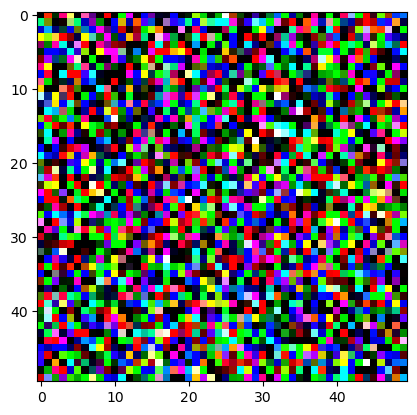

In [124]:
plt.ion()
plt.imshow(input[0].T)

In [117]:
output = m(input)
output

tensor([[[[-1.0843e-01,  1.2851e+00, -4.2413e-01,  ..., -2.2358e-01,
            5.4495e-01,  2.6334e-01],
          [ 2.6019e-01,  6.2342e-01, -8.1166e-02,  ...,  2.4385e-01,
            3.8658e-01,  8.0487e-01],
          [-5.4554e-01,  5.3899e-01,  1.8644e-01,  ...,  5.6654e-01,
           -3.7506e-01,  4.1420e-01],
          ...,
          [-8.7533e-02, -4.7319e-01, -8.2185e-01,  ...,  2.5201e+00,
            2.8818e-01, -1.1172e+00],
          [ 1.7634e+00, -4.1414e-01,  1.5129e-02,  ...,  1.2336e+00,
            4.1439e-01, -9.4247e-01],
          [-1.2582e-01,  2.3094e-01,  3.5593e-01,  ...,  2.2123e-01,
           -1.7505e-01,  2.3430e-01]],

         [[-1.8258e-01, -1.2132e+00,  8.9332e-02,  ...,  8.2407e-01,
            6.5604e-02, -8.9670e-02],
          [ 2.3296e-01, -3.6229e-02, -2.5030e-02,  ..., -1.6152e-01,
           -1.6121e-01, -1.3918e+00],
          [-5.1522e-01, -1.8424e-01,  1.8469e-01,  ..., -1.1343e-03,
            6.8209e-01, -2.5981e-01],
          ...,
     

In [118]:
output.shape

torch.Size([20, 28, 48, 48])